In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
!pip install info-gain
from info_gain import info_gain
from xgboost import XGBClassifier
%matplotlib inline

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
col=["duration", "protocol_type", "service", "flag", "src_bytes","dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins","logged_in", "num_compromised", "root_shell", "su_attempted", "num_root","num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds","is_host_login", "is_guest_login", "count", "srv_count", "serror_rate","srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate","diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count","dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate","dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels"]
att={'normal': 'normal','back': 'DDoS','land': 'DDoS','neptune': 'DDoS','pod': 'DDoS','smurf': 'DDoS','teardrop': 'DDoS','mailbomb': 'DDoS','apache2': 'DDoS','processtable': 'DDoS','udpstorm': 'DDoS','ipsweep': 'Probe','nmap': 'Probe','portsweep': 'Probe','satan': 'Probe','mscan': 'Probe','saint': 'Probe','ftp_write': 'R2L','guess_passwd': 'R2L','imap': 'R2L','multihop': 'R2L','phf': 'R2L','spy': 'R2L','warezclient': 'R2L','warezmaster': 'R2L','sendmail': 'R2L','named': 'R2L','snmpgetattack': 'R2L','snmpguess': 'R2L','xlock': 'R2L','xsnoop': 'R2L','worm': 'R2L','buffer_overflow': 'U2R','loadmodule': 'U2R','perl': 'U2R','rootkit': 'U2R','httptunnel': 'U2R','ps': 'U2R','sqlattack': 'U2R','xterm': 'U2R'}

In [7]:
plt.style.use('ggplot')
class anomalydetection(object):
    def __init__(self,filepath,topfeat=10):
        self.clas1 = None
        self.clas2 = None
        self.clas3 = None
        self.clas4 = None
        self.clas5 = None
        self.clas6 = None
        self.train = []
        self.test = []
        self.trainset=[]
        self.bin_labels=[]
        self.filepath=filepath
        self.topfeat=topfeat
    @staticmethod
    def IGR(self):
        dataset = pd.read_csv(self.filepath, names=col, index_col=False)
        dataset = dataset.sample(frac=1).reset_index(drop=True)
        final=[]
        for i in range(0,41):
          igr=info_gain.info_gain_ratio(dataset.iloc[:,i],dataset['labels'])
          final.append([i,igr])
        sorted_matrix = sorted(final, key=lambda x: x[1],reverse=True)
        return [i[0] for i in sorted_matrix[:self.topfeat]]

    def load_data(self):
        index = self.IGR(self)
        dataset = pd.read_csv(self.filepath, names=col, index_col=False)
        nec=[list(dataset.columns)[i] for i in index]
        dataset = dataset.sample(frac=1).reset_index(drop=True)
        labels = dataset['labels']
        dataset = dataset.iloc[:, index]
        for ind,num in enumerate(index):
          if dataset[nec[ind]].dtype==object:
            dataset[nec[ind]] = dataset[nec[ind]].astype('category').cat.codes
        scaler = StandardScaler()
        dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
        return [dataset, labels]

    def train_clas(self):
      self.train = self.load_data()
      self.train_set, train_labels = self.train
      self.bin_labels = [x == 'normal' for x in train_labels]
      X_train,X_test,y_train,y_test=train_test_split(self.train_set,self.bin_labels,test_size=0.2,random_state=0)
      X=[]
      self.clas1 = SVC(C=10000,gamma="auto")
      self.clas1.fit(X_train, y_train)
      prediction1=self.clas1.predict(X_test)
      print("Accuracy via RBF SVM: {0:.2f}%".format(accuracy_score(y_test, prediction1) * 100 ))
      X.append(round(accuracy_score(y_test, prediction1) * 100,2))
      self.clas2 = SVC(kernel='linear')
      self.clas2.fit(X_train, y_train)
      prediction2=self.clas2.predict(X_test)
      print("Accuracy via Linear SVM: {0:.2f}%".format(accuracy_score(y_test, prediction2) * 100 ))
      X.append(round(accuracy_score(y_test, prediction2) * 100,2))
      self.clas3 = XGBClassifier()
      self.clas3.fit(X_train, y_train)
      xgpred=self.clas3.predict(X_test)
      prediction3=[round(value) for value in xgpred]
      print("Accuracy via XGBoost: {0:.2f}%".format(accuracy_score(y_test, prediction3) * 100 ))
      X.append(round(accuracy_score(y_test, prediction3) * 100,2))
      self.clas4 = LogisticRegression(solver='lbfgs', max_iter=10,random_state=0)
      self.clas4.fit(X_train, y_train)
      prediction4=self.clas4.predict(X_test)
      print("Accuracy via Logistic Regression: {0:.2f}%".format(accuracy_score(y_test, prediction4) * 100 ))
      X.append(round(accuracy_score(y_test, prediction4) * 100,2))
      self.clas5 = KNeighborsClassifier(n_neighbors=5)
      self.clas5.fit(X_train, y_train)
      prediction5=self.clas5.predict(X_test)
      print("Accuracy via K Nearest Neighbors: {0:.2f}%".format(accuracy_score(y_test, prediction5) * 100 ))
      X.append(round(accuracy_score(y_test, prediction5) * 100,2))
      self.clas6 = RandomForestClassifier()
      self.clas6.fit(X_train, y_train)
      prediction6=self.clas6.predict(X_test)
      print("Accuracy via Random Forest Classifier: {0:.2f}%".format(accuracy_score(y_test, prediction6) * 100 ))
      X.append(round(accuracy_score(y_test, prediction6) * 100,2))
      freq_series = pd.Series(X)
      plt.figure(figsize=(12, 8))
      labels = ["RBF SVM","Linear SVM","XGBoost","Logistic Regression","K Nearest Neighbour","Random Forest Method"]
      ax = freq_series.plot(kind='bar')
      ax.set_title('Bar Graph')
      ax.set_xlabel('Accuracy')
      ax.set_ylabel('Frequency')
      ax.set_xticklabels(labels)
      rects = ax.patches
      for rect, label in zip(rects, X):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
                    ha='center', va='bottom')

<ipython-input-7-16749b059f57>:18: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dataset = pd.read_csv(self.filepath, names=col, index_col=False)
<ipython-input-7-16749b059f57>:29: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dataset = pd.read_csv(self.filepath, names=col, index_col=False)


Accuracy via RBF SVM: 98.55%
Accuracy via Linear SVM: 90.24%
Accuracy via XGBoost: 99.64%
Accuracy via Logistic Regression: 90.61%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy via K Nearest Neighbors: 98.49%
Accuracy via Random Forest Classifier: 99.60%


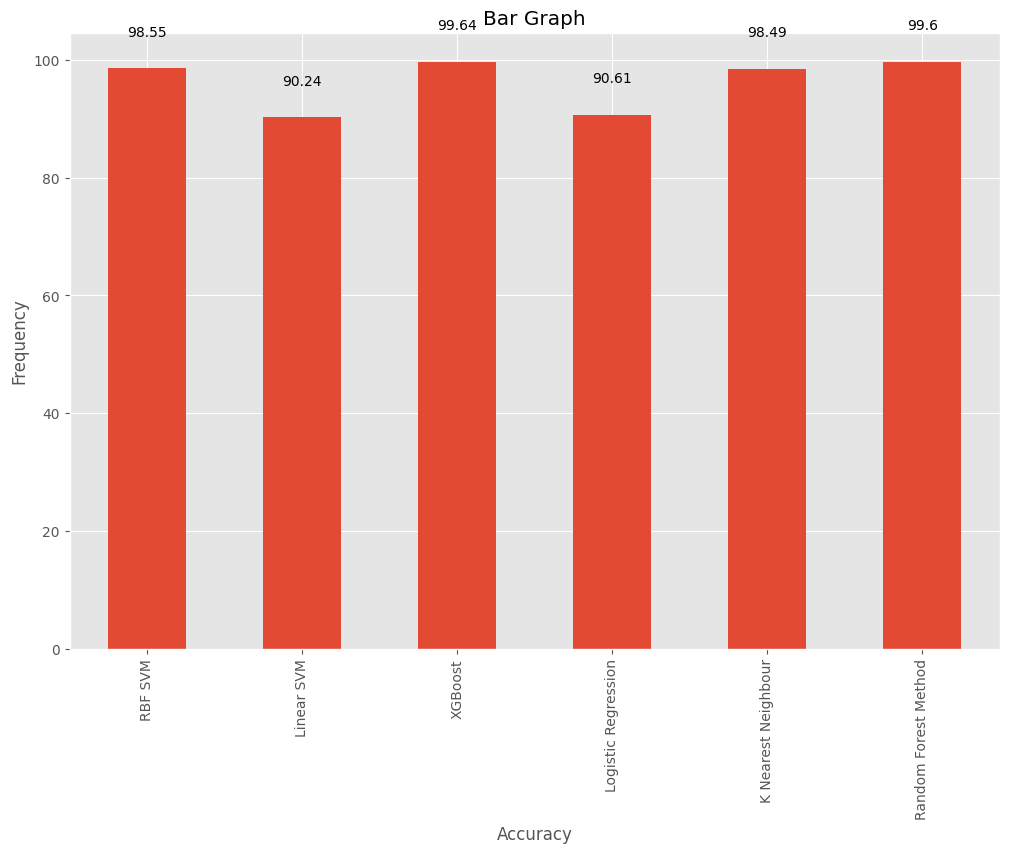

In [8]:
mytr=anomalydetection('/content/gdrive/MyDrive/Colab Notebooks/20 Percent Training Set.csv',10)
mytr.train_clas()